# TUNVESTI – ETL Notebook
## IT300 – Business Intelligence

This notebook performs data cleaning and exploratory data analysis
on historical BVMT stock data (2010–2022) to prepare it for BI dashboards.


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

plt.style.use("default")

# Set working directory to project root
project_root = Path.cwd()
print(f"Working directory: {project_root}")


Working directory: D:\TUNVESTI\TUNVESTI


In [22]:
csv_path = Path("data") / "historical_stocks_2010_2022.csv"

if not csv_path.exists():
    raise FileNotFoundError(f"Data file not found: {csv_path}\nPlease run: python scripts/01_load_kaggle_data.py")

df = pd.read_csv(csv_path)
print(f"✓ Loaded {len(df)} rows from {csv_path}")
df.head()


✓ Loaded 187987 rows from data\historical_stocks_2010_2022.csv


,Ticker,Date,Open,High,Low,Close,Volume
0,AB,2010-01-04,26.500,26.650,26.50,26.650,736
1,AB,2010-01-05,26.650,27.350,26.50,27.200,14632
2,AB,2010-01-06,27.250,27.995,27.20,27.500,11350
3,AB,2010-01-07,27.500,28.150,27.30,28.005,12210
4,AB,2010-01-08,28.395,28.395,27.65,28.000,1108


In [23]:
print("=== DATA OVERVIEW ===")
print(f"Shape: {df.shape}")
print(f"Unique tickers: {df['Ticker'].nunique()}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print("\n=== DATA TYPES ===")
print(df.dtypes)
print("\n=== MISSING VALUES ===")
print(df.isnull().sum())
print("\n=== SUMMARY STATISTICS ===")
print(df.describe())


=== DATA OVERVIEW ===
Shape: (187987, 7)
Unique tickers: 88
Date range: 2010-01-04 to 2022-12-30

=== DATA TYPES ===
Ticker     object
Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

=== MISSING VALUES ===
Ticker     0
Date       0
Open      22
High      22
Low       27
Close     22
Volume     0
dtype: int64

=== SUMMARY STATISTICS ===
                Open           High            Low          Close  \
count  187965.000000  187965.000000  187960.000000  187965.000000   
mean       15.343251      15.440103      15.241624      15.360728   
std        31.804620      31.935038      31.673683      31.821089   
min         0.120000       0.130000       0.120000       0.120000   
25%         3.570000       3.600000       3.513823       3.575000   
50%         7.200000       7.250000       7.121073       7.200000   
75%        14.480000      14.530000      14.390000      14.490000   
max       602.750000     602.750000

In [24]:
print("=== HANDLING MISSING VALUES ===")
print(f"Before: {df[['Open', 'High', 'Low', 'Close']].isnull().sum().sum()} missing values")

price_cols = ['Open', 'High', 'Low', 'Close']
df[price_cols] = df[price_cols].fillna(df[price_cols].median())

print(f"After: {df[['Open', 'High', 'Low', 'Close']].isnull().sum().sum()} missing values")
print("✓ Missing values filled with median")


=== HANDLING MISSING VALUES ===
Before: 93 missing values
After: 0 missing values
✓ Missing values filled with median


In [25]:
print("=== VALIDATING PRICES ===")
print(f"Before: {len(df)} rows")

# Convert to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Remove invalid prices (<=0)
df = df[
    (df['Open'] > 0) &
    (df['High'] > 0) &
    (df['Low'] > 0) &
    (df['Close'] > 0)
]

# Remove invalid volumes
df = df[df['Volume'] >= 0]

print(f"After: {len(df)} rows")
print("✓ Invalid prices removed")


=== VALIDATING PRICES ===
Before: 187987 rows
After: 187987 rows
✓ Invalid prices removed


In [26]:
print("=== REMOVING OUTLIERS (IQR Method) ===")
print(f"Before: {len(df)} rows")

cols = ['Open', 'High', 'Low', 'Close', 'Volume']

Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

# Identify and remove outliers
outliers = (
    (df[cols] < (Q1 - 1.5 * IQR)) |
    (df[cols] > (Q3 + 1.5 * IQR))
).any(axis=1)

rows_removed = outliers.sum()
df = df[~outliers]

print(f"After: {len(df)} rows")
print(f"Outliers removed: {rows_removed}")
print("✓ Outliers removed using IQR method (1.5 × IQR)")


=== REMOVING OUTLIERS (IQR Method) ===
Before: 187987 rows
After: 146245 rows
Outliers removed: 41742
✓ Outliers removed using IQR method (1.5 × IQR)


In [27]:
print("=== CALCULATING DAILY RETURNS ===")

df = df.sort_values(['Ticker', 'Date'])
df['Daily_Return'] = df.groupby('Ticker')['Close'].pct_change()

print(f"Return statistics:")
print(df['Daily_Return'].describe())
print(f"\nDaily returns range: {df['Daily_Return'].min():.2%} to {df['Daily_Return'].max():.2%}")
print("✓ Daily returns calculated")


=== CALCULATING DAILY RETURNS ===
Return statistics:
count    146161.000000
mean          0.000033
std           0.028035
min          -0.758955
25%          -0.007634
50%           0.000000
75%           0.005882
max           2.977778
Name: Daily_Return, dtype: float64

Daily returns range: -75.90% to 297.78%
✓ Daily returns calculated


=== VISUALIZING RETURN DISTRIBUTION ===


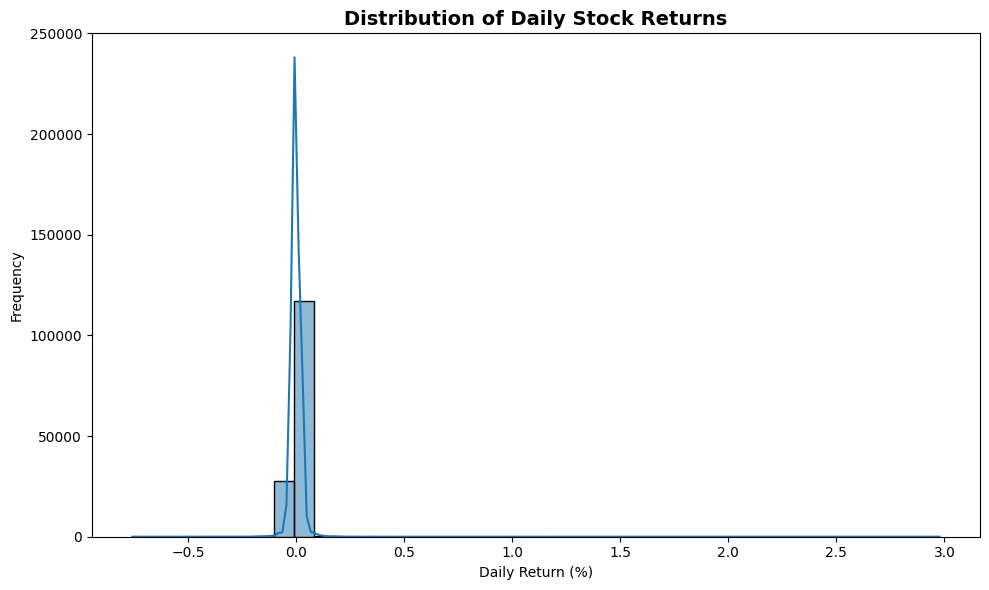

✓ Visualization complete


In [28]:
print("=== VISUALIZING RETURN DISTRIBUTION ===")

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df['Daily_Return'].dropna(), bins=40, kde=True, ax=ax)
ax.set_title("Distribution of Daily Stock Returns", fontsize=14, fontweight='bold')
ax.set_xlabel("Daily Return (%)")
ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

print(f"✓ Visualization complete")


In [29]:
print("=== SAVING CLEANED DATA ===")

output_path = Path("clean_historical_stocks_2010_2022.csv")
df.to_csv(output_path, index=False)

print(f"✓ Saved to: {output_path}")
print(f"  - Rows: {len(df):,}")
print(f"  - Columns: {len(df.columns)}")
print(f"  - File size: {output_path.stat().st_size / 1024 / 1024:.2f} MB")


=== SAVING CLEANED DATA ===
✓ Saved to: clean_historical_stocks_2010_2022.csv
  - Rows: 146,245
  - Columns: 8
  - File size: 9.14 MB


In [30]:
print("\n" + "="*60)
print("ETL PROCESS COMPLETE - DATA QUALITY SUMMARY")
print("="*60)
print(f"✓ Rows: {len(df):,}")
print(f"✓ Columns: {len(df.columns)} ({', '.join(df.columns)})")
print(f"✓ Unique stocks: {df['Ticker'].nunique()}")
print(f"✓ Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"✓ Missing values: {df.isnull().sum().sum()}")
print(f"✓ Output file: {output_path}")
print("="*60)



ETL PROCESS COMPLETE - DATA QUALITY SUMMARY
✓ Rows: 146,245
✓ Columns: 8 (Ticker, Date, Open, High, Low, Close, Volume, Daily_Return)
✓ Unique stocks: 84
✓ Date range: 2010-01-04 to 2022-12-30
✓ Missing values: 84
✓ Output file: clean_historical_stocks_2010_2022.csv
